In [2]:
import pyarrow.parquet as pq
import torch
import random
import time
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



In [3]:
temp = pq.read_table('cleaned_taxi_data.parquet')
temp = temp.to_pandas()
temp

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,...,store_and_fwd_flag_0,store_and_fwd_flag_1,payment_type_1,payment_type_2,payment_type_3,payment_type_4,tip_bin_0,tip_bin_1,tip_bin_2,tip_bin_3
0,1.0,0.90,5.0,3.0,0.5,2.20,0.0,0.3,11.00,2.5,...,1,0,1,0,0,0,0,1,0,0
8,1.0,5.25,18.5,0.5,0.5,4.46,0.0,0.3,26.76,2.5,...,1,0,1,0,0,0,0,1,0,0
9,1.0,1.74,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,...,1,0,0,1,0,0,1,0,0,0
11,3.0,4.30,14.0,3.0,0.5,3.55,0.0,0.3,21.35,2.5,...,1,0,1,0,0,0,0,1,0,0
15,1.0,0.90,5.0,3.0,0.5,0.00,0.0,0.3,8.80,2.5,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710721,1.0,2.34,9.5,0.5,0.5,3.33,0.0,0.3,16.63,2.5,...,1,0,1,0,0,0,0,0,1,0
2710722,1.0,2.36,9.5,0.5,0.5,3.33,0.0,0.3,16.63,2.5,...,1,0,1,0,0,0,0,0,1,0
2710723,1.0,1.16,7.0,0.5,0.5,2.16,0.0,0.3,12.96,2.5,...,1,0,1,0,0,0,0,1,0,0
2710724,1.0,1.50,6.5,0.5,0.5,2.06,0.0,0.3,12.36,2.5,...,1,0,1,0,0,0,0,1,0,0


In [4]:
temp = pq.read_table('cleaned_taxi_data.parquet')
temp = temp.to_pandas()
temp = temp.drop(['total_amount','tip_pct','tip_amount'],axis=1)

trip_info = torch.tensor(temp.values, dtype = torch.float32)

In [5]:
trip_info.shape
#tip_columns_indices = temp.columns.get_loc(['tip_bin_0','tip_bin_1','tip_bin_2','tip_bin_3'])
tip_columns_index0 = temp.columns.get_loc('tip_bin_0')
tip_columns_index1 = temp.columns.get_loc('tip_bin_1')
tip_columns_index2 = temp.columns.get_loc('tip_bin_2')
tip_columns_index3 = temp.columns.get_loc('tip_bin_3')

print(f'{tip_columns_index0},{tip_columns_index1},{tip_columns_index2},{tip_columns_index3}')

169,170,171,172


In [6]:
# Base values
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
NUM_EPOCHS = 50

In [7]:
import torch
from torch.utils.data import random_split

# Normalize and Split Input Data (Train = 75%, Validation = 20%, Test = 5%)
torch.manual_seed(RANDOM_SEED)

# Define the sizes of the splits
train_size = int(0.75 * len(trip_info))
val_size = int(0.2 * len(trip_info))
test_size = len(trip_info) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(trip_info, [train_size, val_size, test_size])


trip_inf_loc_train = list(range(0, 5)) + list(range(6, 169))
trip_inf_loc_val = list(range(0, 5)) + list(range(6, 169))
trip_inf_loc_test = list(range(0, 5)) + list(range(6, 169))

# Indices for targets
tip_inf_loc_train = [169,170,171,172]
tip_inf_loc_val = [169,170,171,172]
tip_inf_loc_test = [169,170,171,172]

In [8]:
# Extract features and labels from train_dataset
x_train = []
y_train = []

for sample in train_dataset:
    features = sample[trip_inf_loc_train]  
    labels = sample[tip_inf_loc_train]    
    x_train.append(features)
    y_train.append(labels)

# Convert lists to tensors
x_train = torch.stack(x_train)
y_train = torch.stack(y_train)
print("X Train size:", x_train.size())
print("y Train size:", y_train.size())

X Train size: torch.Size([1707345, 168])
y Train size: torch.Size([1707345, 4])


In [9]:
x_val = []
y_val = []

for sample in val_dataset:
    features = sample[trip_inf_loc_val]
    labels = sample[tip_inf_loc_val]
    x_val.append(features)
    y_val.append(labels)

# Convert lists to tensors
x_val = torch.stack(x_val)
y_val = torch.stack(y_val)
print("X Val size:", x_val.size())
print("y Val size:", y_val.size())


X Val size: torch.Size([455292, 168])
y Val size: torch.Size([455292, 4])


In [10]:
x_test = []
y_test = []

for sample in test_dataset:
    features = sample[trip_inf_loc_test]  
    labels = sample[tip_inf_loc_test]    
    x_test.append(features)
    y_test.append(labels)

# Convert lists to tensors
x_test = torch.stack(x_test)
y_test = torch.stack(y_test)
print("X Test size:", x_test.size())
print("y Test size:", y_test.size())

X Test size: torch.Size([113824, 168])
y Test size: torch.Size([113824, 4])


In [11]:
# Assuming x_train, y_train, x_val, y_val, x_test, and y_test are already defined

# Create TensorDataset objects for train, validation, and test datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Define batch sizes
batch_size = 64

# Create DataLoader objects for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,drop_last=True)


In [12]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 168)
        features = features.to(device)
        targets = targets.to(device)
        targets = torch.argmax(targets,-1)

        logits = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        predicted_labels = torch.argmax(logits, -1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples

In [13]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes

    ### 1st hidden layer this hidden layer is the main different between softmax regression
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

    ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()

         
    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        #probas = torch.softmax(logits, dim=1) softmax does this automatically
        return logits#, #probas

In [14]:
#################################
### Model Initialization
#################################

#random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=168,
            num_hidden_1=100,
            num_classes=4)



model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


start_time = time.time()
minibatch_cost = []
epoch_cost = []
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 168).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        
        #y_onehot = to_onehot(targets, model.num_classes).to(DEVICE)
        
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
        

#     # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, val_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/26677 | Cost: 1.1711
Epoch: 001/050 | Batch 050/26677 | Cost: 1.0111
Epoch: 001/050 | Batch 100/26677 | Cost: 0.9232
Epoch: 001/050 | Batch 150/26677 | Cost: 0.8709
Epoch: 001/050 | Batch 200/26677 | Cost: 1.0569
Epoch: 001/050 | Batch 250/26677 | Cost: 0.9690
Epoch: 001/050 | Batch 300/26677 | Cost: 0.8450
Epoch: 001/050 | Batch 350/26677 | Cost: 1.0278
Epoch: 001/050 | Batch 400/26677 | Cost: 0.8440
Epoch: 001/050 | Batch 450/26677 | Cost: 0.8845
Epoch: 001/050 | Batch 500/26677 | Cost: 0.8141
Epoch: 001/050 | Batch 550/26677 | Cost: 0.8312
Epoch: 001/050 | Batch 600/26677 | Cost: 0.9184
Epoch: 001/050 | Batch 650/26677 | Cost: 0.9577
Epoch: 001/050 | Batch 700/26677 | Cost: 0.8391
Epoch: 001/050 | Batch 750/26677 | Cost: 1.0056
Epoch: 001/050 | Batch 800/26677 | Cost: 1.0268
Epoch: 001/050 | Batch 850/26677 | Cost: 0.7991
Epoch: 001/050 | Batch 900/26677 | Cost: 0.9994
Epoch: 001/050 | Batch 950/26677 | Cost: 0.9426
Epoch: 001/050 | Batch 1000/26677 | Cost

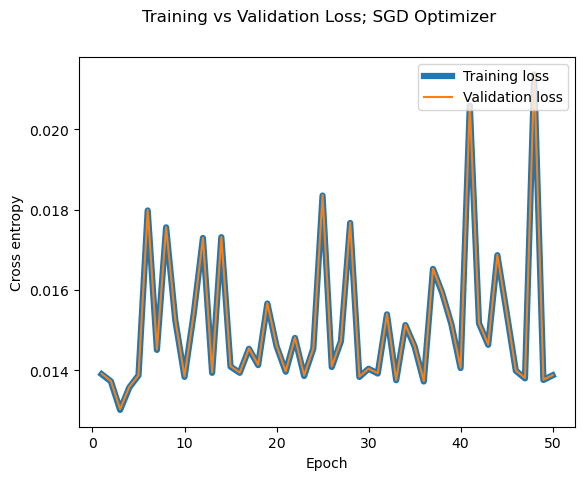

In [18]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss',linewidth=4.5)
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.suptitle('Training vs Validation Loss; SGD Optimizer')
plt.savefig('Training vs Validation Loss; SGD Optimizer')
plt.show()

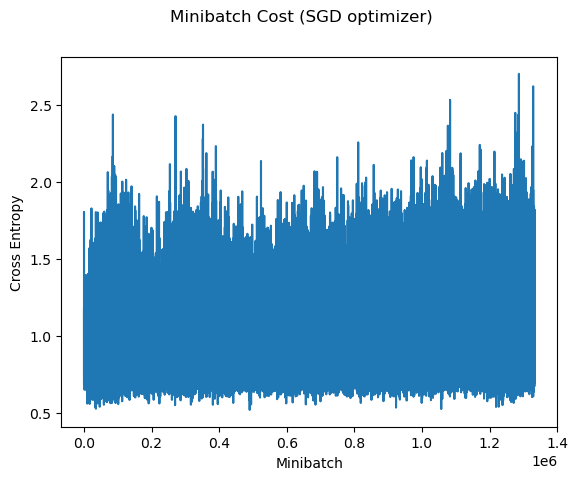

In [21]:

# Convert the lists to PyTorch tensors
minibatch_cost_tensor = torch.tensor(minibatch_cost)


# Convert the tensors to NumPy arrays
minibatch_cost_np = minibatch_cost_tensor.detach().numpy()




# Plot minibatch cost
plt.plot(range(len(minibatch_cost_np)), minibatch_cost_np)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.suptitle('Minibatch Cost (SGD optimizer)')
plt.savefig('Minibatch Cost (SGD optimizer)')
plt.show()


In [22]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 168).to(DEVICE)
            targets = targets.to(DEVICE)
            targets = torch.argmax(targets,-1)
            logits = net(features)
            predicted_labels = torch.argmax(logits, -1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().item() 
    return correct_pred / num_examples * 100

print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Validation Accuracy: %.2f' % compute_accuracy(model, val_loader))


Training Accuracy: 58.72
Validation Accuracy: 58.69


In [23]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 58.77%
